### Ecommerce Purchases Analysis

**Introduction**

Exploratory data analysis (EDA) is used by data specialists to analyze and investigate data sets, and understand the data before making any assumptions. 

EDA can help to quickly find any obvious errors, identify patterns within the data, detect anomalous events, and find interesting relations among the variables.

EDA helps stakeholders to ask the right questions, provide insights and observations, and help create new features that can be used for more sophisticated data analysis or modeling, machine learning and AI.

**Background**

This project will perform EDA on dummy eCommerce data for online purchases by customers in the US. A number of techniques will be applied to help understand:
- overall data quality
- volume of data
- types of data
- balance or imbalanced
- any interesting insights


In [82]:
# 1. Importing required libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # visualisation
import matplotlib.dates as mdates
import kaleido
import seaborn as sns            # visualisation
%matplotlib inline 
sns.set_theme(color_codes=True)

from matplotlib.ticker import FormatStrFormatter
from matplotlib.dates import DateFormatter
from matplotlib import cm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pathlib import Path, PureWindowsPath
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose 

# split the dataset
from pandas import read_csv
from pandas.tseries.offsets import MonthEnd
from random import sample, randint, seed

import datetime
import os.path
from os import path
import warnings

# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action='ignore', category=UserWarning)
# warnings.simplefilter(action='ignore', category=RuntimeWarning)

pd.set_option('display.max_columns', 500)

print('initialisation complete')

initialisation complete


In [83]:
# read in data downloaded from Kaggle
# https://www.kaggle.com/code/ahmedashrafahmed/ecommerce-purchases-analysis/input

ecom = pd.read_csv('../data/raw/Ecommerce Purchases')

ecom.head()

,Address,Lot,AM or PM,Browser Info,Company,Credit Card,CC Exp Date,CC Security Code,CC Provider,Email,Job,IP Address,Language,Purchase Price
0,"16629 Pace Camp Apt. 448\nAlexisborough, NE 77...",46 in,PM,Opera/9.56.(X11; Linux x86_64; sl-SI) Presto/2...,Martinez-Herman,6011929061123406,02/20,900,JCB 16 digit,pdunlap@yahoo.com,"Scientist, product/process development",149.146.147.205,el,98.14
1,"9374 Jasmine Spurs Suite 508\nSouth John, TN 8...",28 rn,PM,Opera/8.93.(Windows 98; Win 9x 4.90; en-US) Pr...,"Fletcher, Richards and Whitaker",3337758169645356,11/18,561,Mastercard,anthony41@reed.com,Drilling engineer,15.160.41.51,fr,70.73
2,Unit 0065 Box 5052\nDPO AP 27450,94 vE,PM,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,"Simpson, Williams and Pham",675957666125,08/19,699,JCB 16 digit,amymiller@morales-harrison.com,Customer service manager,132.207.160.22,de,0.95
3,"7780 Julia Fords\nNew Stacy, WA 45798",36 vm,PM,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_0 ...,"Williams, Marshall and Buchanan",6011578504430710,02/24,384,Discover,brent16@olson-robinson.info,Drilling engineer,30.250.74.19,es,78.04
4,"23012 Munoz Drive Suite 337\nNew Cynthia, TX 5...",20 IE,AM,Opera/9.58.(X11; Linux x86_64; it-IT) Presto/2...,"Brown, Watson and Andrews",6011456623207998,10/25,678,Diners Club / Carte Blanche,christopherwright@gmail.com,Fine artist,24.140.33.94,es,77.82


In [84]:
ecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Address           10000 non-null  object 
 1   Lot               10000 non-null  object 
 2   AM or PM          10000 non-null  object 
 3   Browser Info      10000 non-null  object 
 4   Company           10000 non-null  object 
 5   Credit Card       10000 non-null  int64  
 6   CC Exp Date       10000 non-null  object 
 7   CC Security Code  10000 non-null  int64  
 8   CC Provider       10000 non-null  object 
 9   Email             10000 non-null  object 
 10  Job               10000 non-null  object 
 11  IP Address        10000 non-null  object 
 12  Language          10000 non-null  object 
 13  Purchase Price    10000 non-null  float64
dtypes: float64(1), int64(2), object(11)
memory usage: 1.1+ MB


**Data Quality**

The data appears to be quite clean with regards to missing or null values not present in the data.

In [85]:
# check for any missing or null values
print(ecom.isnull().sum())

Address             0
Lot                 0
AM or PM            0
Browser Info        0
Company             0
Credit Card         0
CC Exp Date         0
CC Security Code    0
CC Provider         0
Email               0
Job                 0
IP Address          0
Language            0
Purchase Price      0
dtype: int64


**Descriptive Statistics**

Summary of the datset's central tendency, dispersion and distribution shape.

The min Purchase Prices is $0.00 and maximum is $99.99 - so all Purchase are under $100

In [86]:
ecom.describe()

,Credit Card,CC Security Code,Purchase Price
count,1.000000e+04,10000.000000,10000.000000
mean,2.341374e+15,907.217800,50.347302
std,2.256103e+15,1589.693035,29.015836
min,6.040186e+10,0.000000,0.000000
25%,3.056322e+13,280.000000,25.150000
50%,8.699942e+14,548.000000,50.505000
75%,4.492298e+15,816.000000,75.770000
max,6.012000e+15,9993.000000,99.990000


**Removal of columns**

Some columns are not required for detailed analysis - like Credit Card number - as this is 100% unique and doesn't tell us anything. 

If we were interested in email service providers, for example, to target marketing channels - we could extract that information. However for this EDA, email provider will not be explored further.

Credit Card Provider - can provide some meaningful customer insights, so is helpful to keep for further analysis.

In [87]:
# remove unhelpful columns
ecom_df = ecom.copy()
ecom_df = ecom_df.drop(['Credit Card', 'CC Exp Date', 'CC Security Code', 'Email', 'IP Address'], axis=1)

ecom_df.head()	

,Address,Lot,AM or PM,Browser Info,Company,CC Provider,Job,Language,Purchase Price
0,"16629 Pace Camp Apt. 448\nAlexisborough, NE 77...",46 in,PM,Opera/9.56.(X11; Linux x86_64; sl-SI) Presto/2...,Martinez-Herman,JCB 16 digit,"Scientist, product/process development",el,98.14
1,"9374 Jasmine Spurs Suite 508\nSouth John, TN 8...",28 rn,PM,Opera/8.93.(Windows 98; Win 9x 4.90; en-US) Pr...,"Fletcher, Richards and Whitaker",Mastercard,Drilling engineer,fr,70.73
2,Unit 0065 Box 5052\nDPO AP 27450,94 vE,PM,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,"Simpson, Williams and Pham",JCB 16 digit,Customer service manager,de,0.95
3,"7780 Julia Fords\nNew Stacy, WA 45798",36 vm,PM,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_0 ...,"Williams, Marshall and Buchanan",Discover,Drilling engineer,es,78.04
4,"23012 Munoz Drive Suite 337\nNew Cynthia, TX 5...",20 IE,AM,Opera/9.58.(X11; Linux x86_64; it-IT) Presto/2...,"Brown, Watson and Andrews",Diners Club / Carte Blanche,Fine artist,es,77.82


**Extract Specific Data**

Some columns contain additional information that isn't 100% standard column-text. However we can extract addtional specific information that might help understand customers or their behaviour - that thankfully starts in the same column, or has the same column delimiter.

- browser name - would this help in the modelling process
- job title - can this help identify the main audience, and least-main audience

In [88]:
# Extract other specific information

# type of Browser
ecom_df['Browser_Name'] = [x.split('/')[0] for x in ecom_df['Browser Info']]

# Job title only
ecom_df['Job_Title'] = [x.split(',')[0] for x in ecom_df['Job']]

# remove the original detailed information
ecom_df = ecom_df.drop(['Browser Info','Job'], axis=1)

# view sample of results
ecom_df.head()

,Address,Lot,AM or PM,Company,CC Provider,Language,Purchase Price,Browser_Name,Job_Title
0,"16629 Pace Camp Apt. 448\nAlexisborough, NE 77...",46 in,PM,Martinez-Herman,JCB 16 digit,el,98.14,Opera,Scientist
1,"9374 Jasmine Spurs Suite 508\nSouth John, TN 8...",28 rn,PM,"Fletcher, Richards and Whitaker",Mastercard,fr,70.73,Opera,Drilling engineer
2,Unit 0065 Box 5052\nDPO AP 27450,94 vE,PM,"Simpson, Williams and Pham",JCB 16 digit,de,0.95,Mozilla,Customer service manager
3,"7780 Julia Fords\nNew Stacy, WA 45798",36 vm,PM,"Williams, Marshall and Buchanan",Discover,es,78.04,Mozilla,Drilling engineer
4,"23012 Munoz Drive Suite 337\nNew Cynthia, TX 5...",20 IE,AM,"Brown, Watson and Andrews",Diners Club / Carte Blanche,es,77.82,Opera,Fine artist


**Language and Purchase Price**

Does a customers main language indicate how much they spend on a product?

The box-plot shows quite a consistent spend across languages - which also demonstrates balanced data for modelling for this feature.

<Axes: xlabel='Language', ylabel='Purchase Price'>

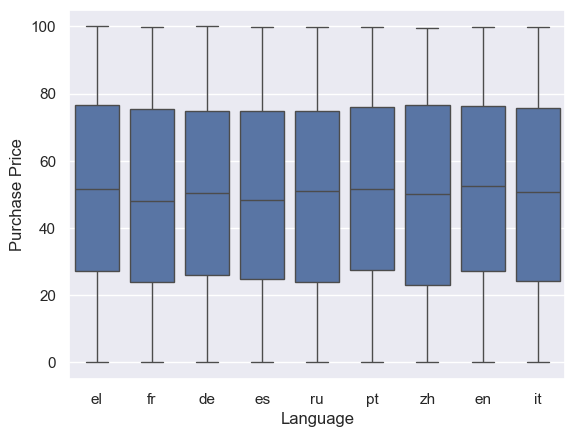

In [89]:
# visualise purchase price to the different languagues
sns.boxplot(data=ecom_df, x='Language', y='Purchase Price')

**Language Frequency**

Is there a dominant language in the data?

The box-plot shows quite a consistent frequency count across languages - which also demonstrates balanced data for modelling for this feature.

Text(0.5, 0, 'Language')

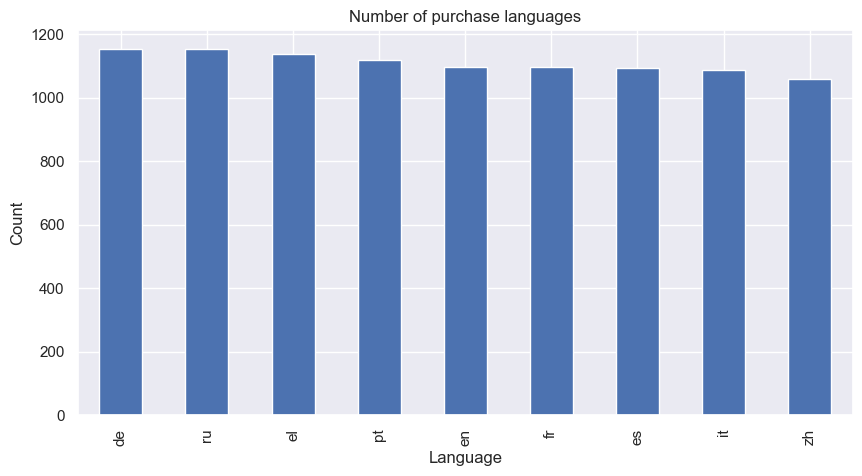

In [90]:
# Histogram of the frequency of occurrence of variables in an interval

ecom_df.Language.value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
plt.title("Number of purchase languages")
plt.ylabel('Count')
plt.xlabel('Language')

**Job Frequency**

What types of jobs do customers who purchase this product come from?

1. The Top-3 jobs have technical backgrounds - Engineer (double the number of the next 2), Designer, Scientist
2. The Bottom-3 jobs are the total opposite non-technical - Dietician, Special. Needs Teacher, Social Worker

This tells us the products being purchased are very technical in nature. Is the product a type of device, or technial software application?

Text(0.5, 0, 'Job_Title')

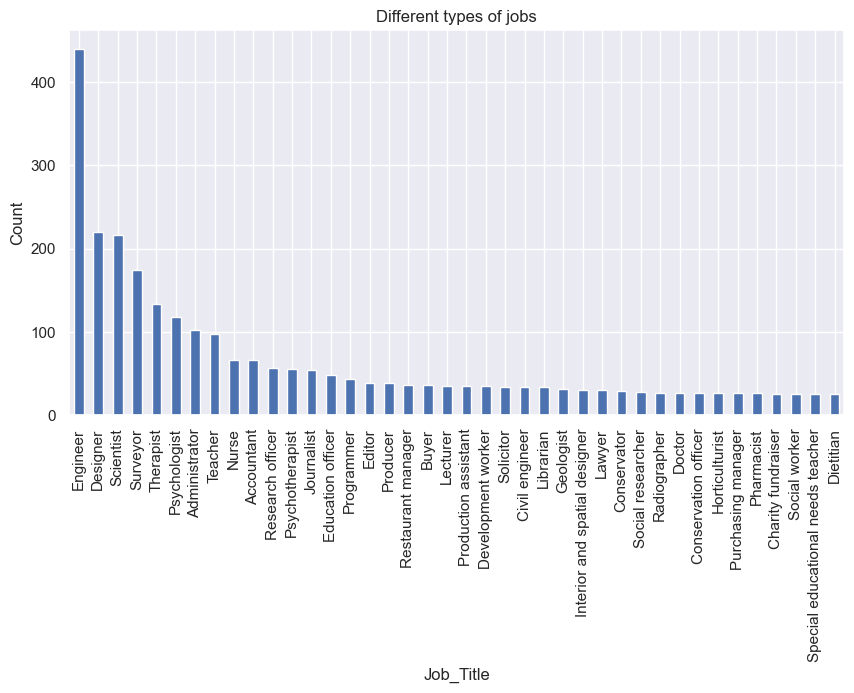

In [91]:
# Histogram of the frequency of different job titles

ecom_df.Job_Title.value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
plt.title("Different types of jobs")
plt.ylabel('Count')
plt.xlabel('Job_Title')

**Type of Internet Browsers**

In the data there are only 2 types of internet browsers. This is in line with the dummy data created - it was only given 2 options. 

It also shows data imbalance for predictive modelling - the data is heavily imbalanced towards Mozilla - so would be most likely predict more purchases by Mozilla users.

Text(0.5, 0, 'Browser_Name')

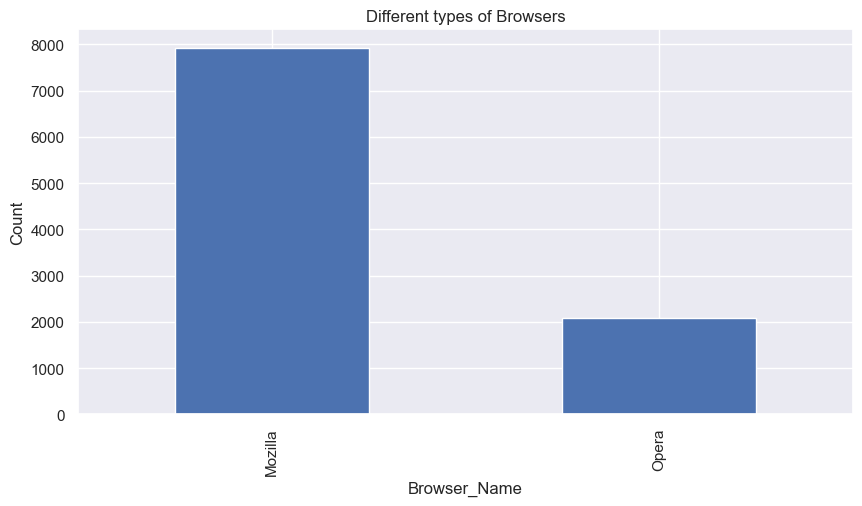

In [92]:
# Histogram of the frequency of different browsers

ecom_df.Browser_Name.value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
plt.title("Different types of Browsers")
plt.ylabel('Count')
plt.xlabel('Browser_Name')

**Purchase Time of Day**

There is a fairly even split for morning and afternoon purchases - also indicating good data balance for predictive modelling training.

Text(0.5, 0, 'AM or PM')

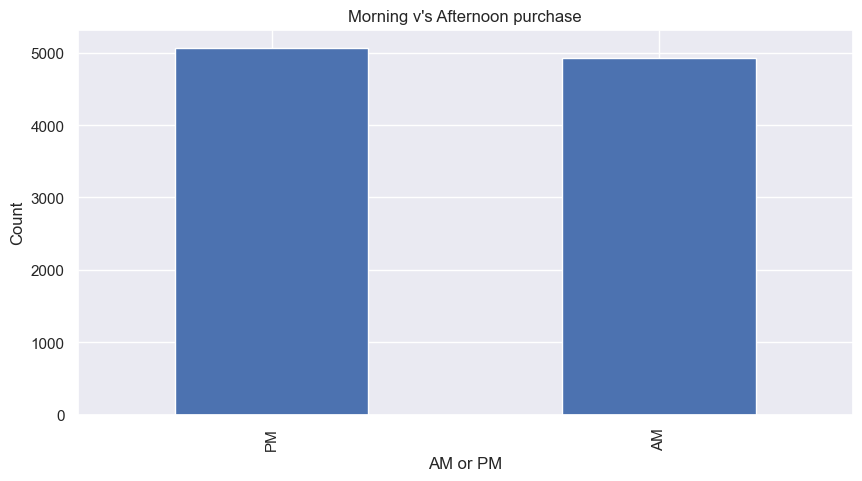

In [93]:
# Histogram of the frequency of morning v's afternoon

ecom_df['AM or PM'].value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
plt.title("Morning v's Afternoon purchase")
plt.ylabel('Count')
plt.xlabel('AM or PM')

**Group Purchase Price Data**

Group individual price data into $10 'buckets' - 10, 20, 30, ... up to 100. We can see how much customers are spending, smaller or larger overall purchases.

In [94]:
# Function to group Purchase Price

def fn_Price_Group(purch_price):

    price_result = '0'

    if purch_price <= 1:
        price_result = '<= 1'
    elif purch_price <= 10:
        price_result = '<= 10'
    elif purch_price <= 20:
        price_result = '<= 20'
    elif purch_price <= 30:
        price_result = '<= 30'
    elif purch_price <= 40:
        price_result = '<= 40'
    elif purch_price <= 50:
        price_result = '<= 50'
    elif purch_price <= 60:
        price_result = '<= 60'
    elif purch_price <= 70:
        price_result = '<= 70'
    elif purch_price <= 80:
        price_result = '<= 80'
    elif purch_price <= 90:
        price_result = '<= 90'
    elif purch_price <= 100:
        price_result = '<= 100'
    else: 
        price_result = 'n/a'

    return price_result

In [95]:
# use list comprehension & function to group 'Purchase Price' into buckets
ecom_df['Price_Group'] = [fn_Price_Group(x) for x in ecom_df['Purchase Price']]

ecom_df.head()

,Address,Lot,AM or PM,Company,CC Provider,Language,Purchase Price,Browser_Name,Job_Title,Price_Group
0,"16629 Pace Camp Apt. 448\nAlexisborough, NE 77...",46 in,PM,Martinez-Herman,JCB 16 digit,el,98.14,Opera,Scientist,<= 100
1,"9374 Jasmine Spurs Suite 508\nSouth John, TN 8...",28 rn,PM,"Fletcher, Richards and Whitaker",Mastercard,fr,70.73,Opera,Drilling engineer,<= 80
2,Unit 0065 Box 5052\nDPO AP 27450,94 vE,PM,"Simpson, Williams and Pham",JCB 16 digit,de,0.95,Mozilla,Customer service manager,<= 1
3,"7780 Julia Fords\nNew Stacy, WA 45798",36 vm,PM,"Williams, Marshall and Buchanan",Discover,es,78.04,Mozilla,Drilling engineer,<= 80
4,"23012 Munoz Drive Suite 337\nNew Cynthia, TX 5...",20 IE,AM,"Brown, Watson and Andrews",Diners Club / Carte Blanche,es,77.82,Opera,Fine artist,<= 80


**Purchase Price Groups**

The chart shows fairly consistent spending across each $10 purchase bucket.

I was also interested if there were many purchases less than $1. This is a fairly small group - and is probably due to the creation of dummy data, not real life purchasing data.

Text(0.5, 0, 'Price_Group')

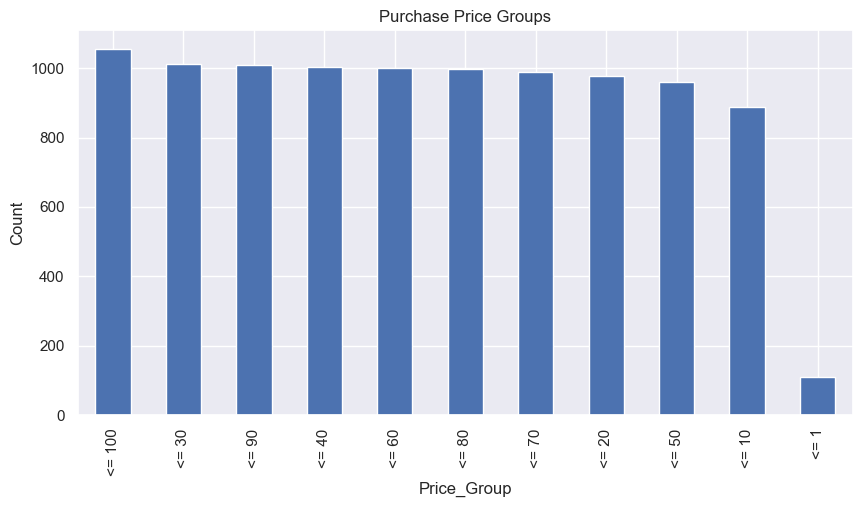

In [96]:
# Histogram of the frequency of Purchase Price Groups

ecom_df['Price_Group'].value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
plt.title("Purchase Price Groups")
plt.ylabel('Count')
plt.xlabel('Price_Group')

**Purchase Value**

We can investigate if customers are making smaller low-value purchases, medium-value, or high-value purchases, by grouping purchase pricess data:

1. low value <= $30
2. medium value between $30 and $70
3. high value over $70

This is arbitrary for this project.

In [97]:
# Investigate Price Value - low, med, high

def fn_Price_Value(purch_price):

    price_result = ''

    if purch_price <= 30:
        price_result = 'low < 30'
    elif purch_price <= 70:
        price_result = 'med 31-70'
    elif purch_price <= 100:
        price_result = 'high 80+'
    else: 
        price_result = 'n/a'

    return price_result

In [98]:
# use list comprehension & function to group 'Purchase Price' into buckets
ecom_df['Price_Value'] = [fn_Price_Value(x) for x in ecom_df['Purchase Price']]

ecom_df.head()

,Address,Lot,AM or PM,Company,CC Provider,Language,Purchase Price,Browser_Name,Job_Title,Price_Group,Price_Value
0,"16629 Pace Camp Apt. 448\nAlexisborough, NE 77...",46 in,PM,Martinez-Herman,JCB 16 digit,el,98.14,Opera,Scientist,<= 100,high 80+
1,"9374 Jasmine Spurs Suite 508\nSouth John, TN 8...",28 rn,PM,"Fletcher, Richards and Whitaker",Mastercard,fr,70.73,Opera,Drilling engineer,<= 80,high 80+
2,Unit 0065 Box 5052\nDPO AP 27450,94 vE,PM,"Simpson, Williams and Pham",JCB 16 digit,de,0.95,Mozilla,Customer service manager,<= 1,low < 30
3,"7780 Julia Fords\nNew Stacy, WA 45798",36 vm,PM,"Williams, Marshall and Buchanan",Discover,es,78.04,Mozilla,Drilling engineer,<= 80,high 80+
4,"23012 Munoz Drive Suite 337\nNew Cynthia, TX 5...",20 IE,AM,"Brown, Watson and Andrews",Diners Club / Carte Blanche,es,77.82,Opera,Fine artist,<= 80,high 80+


**Purchase Value**

Medium value purchases is the majority of customers in this dataset.

Low value, and high value, are quite similar.

There is not a great difference in the frequency of these purchase value groups - indicating good data balance for predictive modelling.

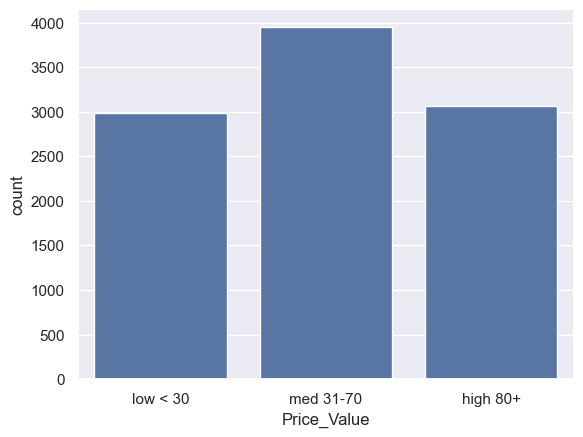

In [99]:
# Histogram of the frequency of Purchase Value

# set categorical order
ecom_df['Price_Value'] = pd.Categorical(ecom_df['Price_Value'], 
                                        categories=['low < 30', 'med 31-70', 'high 80+'], 
                                        ordered=True)

ax = sns.countplot(x='Price_Value', data=ecom_df)


**Credit Card Provider**

The chart shows 2 dominate credit card providers - and the remaining are quite consistent around half of the 2 dominant onces. This appears to be OK data balance for modelling.

The types of credit cards also aligns to the type of product purchased by the type of customers (based on job title) - along the lines that it is a technical related product.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'JCB 16 digit'),
  Text(1, 0, 'VISA 16 digit'),
  Text(2, 0, 'JCB 15 digit'),
  Text(3, 0, 'American Express'),
  Text(4, 0, 'Maestro'),
  Text(5, 0, 'Voyager'),
  Text(6, 0, 'Discover'),
  Text(7, 0, 'Mastercard'),
  Text(8, 0, 'VISA 13 digit'),
  Text(9, 0, 'Diners Club / Carte Blanche')])

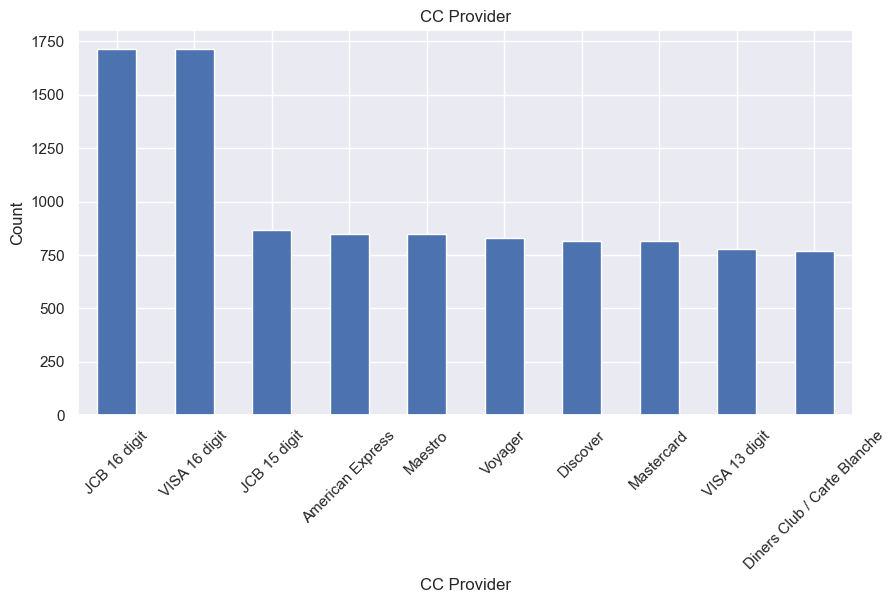

In [100]:
# Histogram of the frequency of CC Provider

ecom_df['CC Provider'].value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
plt.title("CC Provider")
plt.ylabel('Count')
plt.xlabel('CC Provider')
plt.xticks(rotation = 45)

In [101]:
# Explore Address - sample: 74428 Brian Trail Suite 639\nAllenburgh, KY 33519
# newline char \n - is the start of address, format: suburb, state zipcode

ecomm_addr = ecom_df.copy()

# extract address, format: suburb, state zipcode
ecomm_addr['Suburb_Prep'] = [x.split('\n')[1] for x in ecomm_addr['Address']]

# extract state zipcode - get everything to the right of the separating comma
ecomm_addr['State_Prep'] = [x.split(',')[1] if x.find(',') > -1 else x for x in ecomm_addr['Suburb_Prep'] ]

# extract state only - there is a space at the very start, so get index 1
ecomm_addr['State'] = [x.split(' ')[1] for x in ecomm_addr['State_Prep'] ]

# final value counts of state only
ecomm_addr.value_counts('State', ascending=False)

State
AP    376
AA    351
AE    331
IN    183
VI    178
     ... 
CO    133
SC    131
VT    131
NM    130
TN    127
Name: count, Length: 62, dtype: int64

**Customer Location by State**

The chart shows the 3 highest customer purchase states - AA, AE, AP - are in fact US military mail codes. These do not exist on the US map - so we can exclude them from the chloropleth map below.

- AA - U.S. Armed Forces – Americas			
- AE - U.S. Armed Forces – Europe				
- AP - U.S. Armed Forces – Pacific	

This could indicate that the product sold is highly useful for military customers.

Text(0.5, 0, 'State')

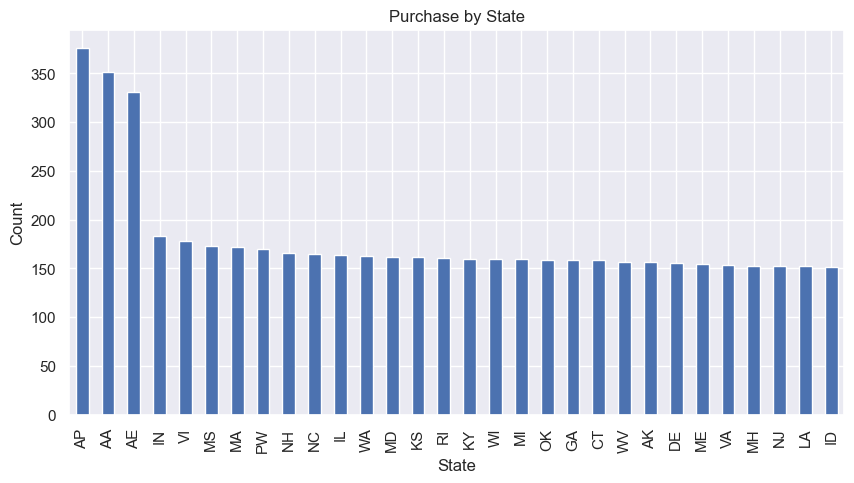

In [104]:
# Histogram of the frequency of states

ecomm_addr['State'].value_counts().nlargest(40)[0:30].plot(kind='bar', figsize=(10,5))
plt.title("Purchase by State")
plt.ylabel('Count')
plt.xlabel('State')

**Total Purchase Amount by State**

Which states spent the most, and spent the least - based on total amount purchased

ie: sum(Purchase Price)

In [109]:
# calculate sum(Purchase Price) of each State

state_price = ecomm_addr.groupby(['State'])['Purchase Price'].sum().reset_index()

state_price.sort_values('Purchase Price', ascending=False)

,State,Purchase Price
4,AP,19563.98
0,AA,18096.87
1,AE,16387.21
21,IN,9415.40
25,MA,9394.40
...,...,...
40,NM,6812.17
7,AZ,6804.29
9,CO,6413.53
52,TN,6287.53


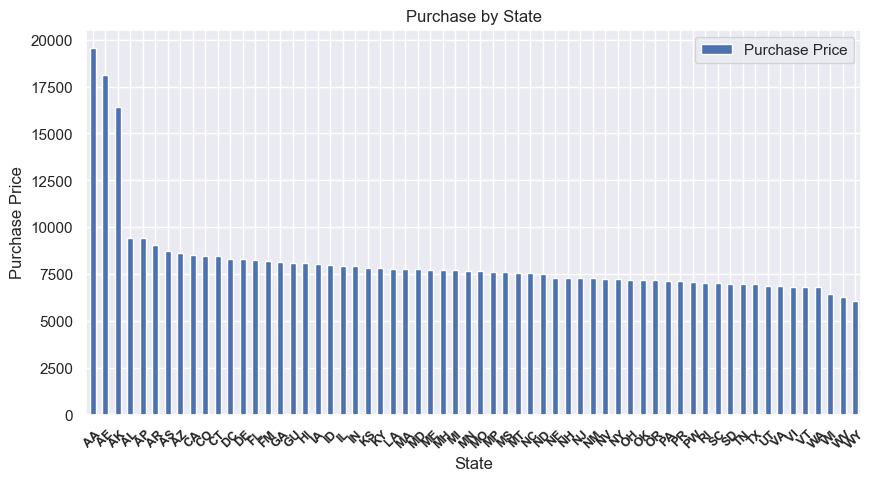

In [110]:
# plot bar chart based on sum(Purchase Price) of each State
state_price.sort_values('Purchase Price', ascending=False).plot(kind='bar', figsize=(10,5))

plt.title("Purchase by State")
plt.ylabel('Purchase Price')
plt.xlabel('State')

x_pos = np.arange(len(state_price['State']))

plt.xticks(x_pos, state_price['State'], rotation=45, fontweight='bold', fontsize='9');

**Set up labels** for static US map - purely for displaying in GitHub

In [105]:
# count the number of purchases by State - notice the top 3 values do not match US "map" codes - they are military mail codes
state_count = ecomm_addr['State'].value_counts().rename_axis('State').to_frame('No. Purch').reset_index()

# state_count['State_Purch_0'] = [x + '\n' for x in state_count['State']]
state_count['State_Purch'] = [' '.join([x, str(y)]) for (x,y) in zip(state_count['State'], state_count['No. Purch'])]

state_count

,State,No. Purch,State_Purch
0,AP,376,AP 376
1,AA,351,AA 351
2,AE,331,AE 331
3,IN,183,IN 183
4,VI,178,VI 178
...,...,...,...
57,CO,133,CO 133
58,SC,131,SC 131
59,VT,131,VT 131
60,NM,130,NM 130


**Customer Location Map**

Ignoring the US military mail codes - we can easily plot the remaining US states on a chloropleth map.

GitHub won't show the interacive map. A work around for GitHub is to show a static map instead.

In [106]:
# this module is used to create entire figures at once
import plotly.io as pio
import plotly.express as px

# create figure 
# colours 'rdbu','blues', 'ylgnbu', 'twilight','icefire','delta','spectral','rdylgn','solar','ylorrd','vidris','sunset'
# ignore 3 highest values as they are military mail codes and the map won't work
fig = px.choropleth(state_count[3:], locations='State', locationmode="USA-states", 
                    scope="usa",
                    color='No. Purch',                   
                    color_continuous_scale='rdbu'
)

fig.update_layout(
    title="Purchase by US State",
    autosize=False,
    width=900,
    height=500
)

# interactive map in notebook - won't appear in GitHub
fig.show() 

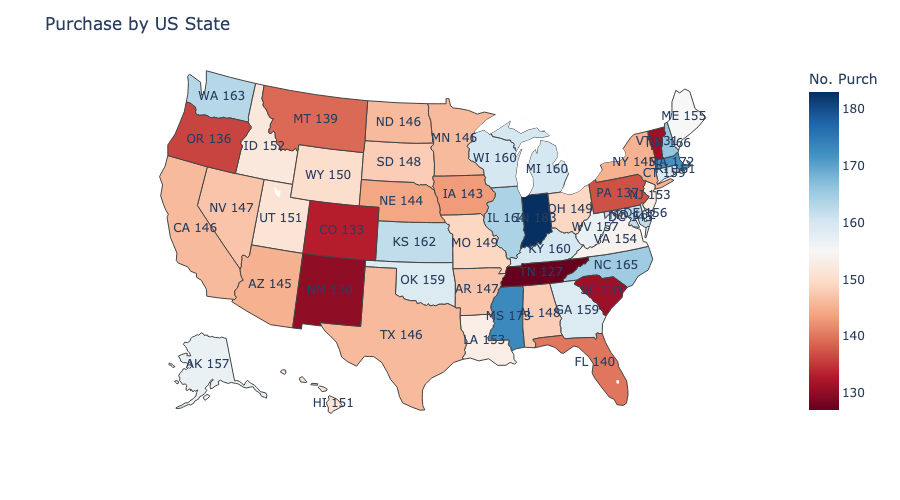

In [107]:

fig.add_scattergeo(
    locations=state_count['State'],
    locationmode="USA-states", 
    text=state_count['State_Purch'],
    mode='text'
)

# static map in GitHub
fig.show("png", engine="kaleido")

## References ##
Dummy Source Data https://www.kaggle.com/code/ahmedashrafahmed/ecommerce-purchases-analysis/input<br>
Exploratory Data Analysis https://www.ibm.com/topics/exploratory-data-analysis<br>
Plotly Choropleth Maps https://www.geeksforgeeks.org/choropleth-maps-using-plotly-in-python/#google_vignette<br>
Convert Plotly to Static Image https://pypi.org/project/kaleido/<br>